# Taryn Michael
# Advanced Machine Learning
# Assignment 3
# Implementing Gaussian Mixture Models vs K-means for Clustering

This notebook is based on the article by <a href = https://www.sciencedirect.com/science/article/pii/S1877050920309820> (Patel & Kushwaha, 2020) </a> which compares K-means and Gaussian Mixture Models to evaluate cluster representations of the two methods for heterogeneity in resource usage of Cloud workloads. 

Here, we will be implementing the use of Gaussian Mixture Models and K-means for clustering, and compare the results of the two methods.

**Firstly, what is clustering?**
<br/>
Clustering can be defined as the process of grouping data together based on some similarity measure. It can be hierarchical or partitional, overlapping or fuzzy, exclusive, complete or partial. Clusters may also be well-seperated, prototype-based, graph-based, or density based.

**K-means**

K-means is defined under partitional clustering techniques, whereby data objects are divided into non-overlapping groups. It is also a prototype-based clustering technique.

The K-means algorithm uses Expectation Maximization algorithm to determine the cluster membership which reduces the Sum of Squared Errors (SSE), which is the SSE of each datapoint and its nearest centroid.

Given k which is the number of clusters, the K-means clustering algorithm can be defined as follows:

1. Randomly initialize k centroids from the dataset.
2. Repeat until convergence: <br/>
    2.1. For each data point, recompute the distance to each centroid and assign each point to the cluster with the nearest centroid. <br/>
    2.2. Recompute the mean for each cluster and update the cluster centroids.

K-means is a simple and relatively easy to understand algorithm. However, its simplicity does indeed lead to practical challenges in its application. Its use of simple distance-from-cluster-center to assign cluster membership also leads to poor performance for many real world situations. 

Further challenges related to K-means Algorithm:

1. K-Means has no mechanism to handle the uncertainty when a data point is close to more than one cluster centroid.
2. K-Means fails to produce optimal clusters for complex, non-linear decision boundaries.
3.  It is sensitive to initial guess of centroids. Different initializations may lead to different clusters.

**Gaussian Mixture Models (GMM)**
<br/>
A GMM is an unsupervised clustering technique that forms ellipsoidal shaped clusters based on probability density
estimations using the Expectation-Maximization. Each cluster is modelled as a Gaussian distribution. The mean and
the covariance rather than only the mean as in K-Means, give GMMs the ability to provide a better quantitative
measure of fitness per number of clusters.
A GMM is represented as a linear combination of the basic Gaussian probability distribution, also known as the Normal Distribution.

The Expectation Maximization algorithm gives maximum likelihood estimates for GM in terms of the mean vector µ, the covariance
matrix Σ and the mixing coefficients π. Multiple random initializations is one way to prevent
EM from converging to local maxima for log likelihood function with multiple local maximum


The most important thing to know about GMs is that the convergence of this model is based on the EM (expectation-maximization) algorithm. It is somewhat similar to K-Means and it can be summarized as follows:
1. Initialize μ, ∑, and mixing coefficient π and evaluate the initial value of the log likelihood L
2. Evaluate the responsibility function using current parameters
3. Obtain new μ, ∑, and π using newly obtained responsibilities
4. Compute the log likelihood L again. Repeat steps 2–3 until the convergence.
The Gaussian Mixtures will also converge to a local minimum.


**Comparing K-means and GMM in terms of key K-means challenges:**
<br/>
Key challenges with K-Means clustering
1. Optimal Number of Clusters: The Elbow method is a technique for finding number of clusters, k. In the plot of
within-cluster SSE for different number of clusters, k is that value beyond which the distortions begin to approach
a constant value. In scikit-learn, SSE is obtained by the inertia attribute of the KMeans model.
2. Initial Centroids Selection: Initial cluster centroids are determined using the K-Means++ algorithm, which is a
technique for obtaining initial guesses for centroids. An inappropriate choice of initial centroids may lead
to bad cluster quality and slow convergence rates.
3. Convergence Rate: This can be controlled by setting a maximum number of iterations for EM. In scikit-learn,
the K-Means algorithm stops if it converges earlier than the maximum number of iterations. In situations where
K-Means does not converge, the algorithm stops when changes in within-cluster SSE is less than a tolerance
value. In the experiments, this value is set to 1e-05.

Clustering with Gaussian Mixtures
1. Optimal number of Components: GMM is a generative model that gives a probability distribution for the data set.
An optimal number of components avoids overfitting or underfitting and can be determined by evaluating the model
likelihood using cross-validation or analytic criterion. 

The Akaike Information Criterion (AIC) and the Bayesian
Information criterion (BIC) 

These are analytic methods that estimate the goodness-of-fit of statistical models relative to each
other for a given data set. They provide a quantitative measure of how general the model is, in terms of accuracy of
representing future data using the process that generated the current data. AIC and BIC use a penalty for overfitting
and under-fitting and this value is larger for BIC than that by AIC

`Since we do not have access to the dataset used in the paper, we will first implement the two methods on generated data to explain the two methods, with their pros and cons, and then we will futher explore it by implementing it on the Popular Iris dataset.`

# Implementing K-means and GMM on generated data


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

If we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [118]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=600, centers=6,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

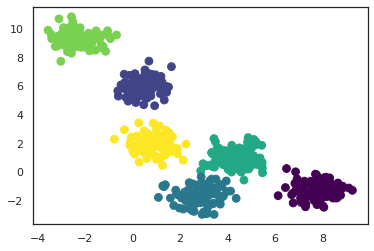

In [119]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(6, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=60, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two lower clusters, such that we might not have complete confidence in the cluster assigment of points between them.
Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function:

In [120]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=60, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#666666', lw=3, alpha=0.5, zorder=1))

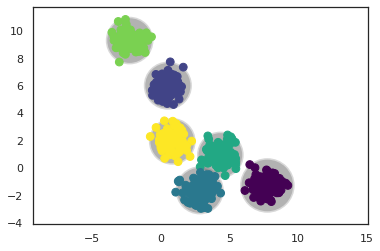

In [121]:
kmeans = KMeans(n_clusters=6, random_state=0)
plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

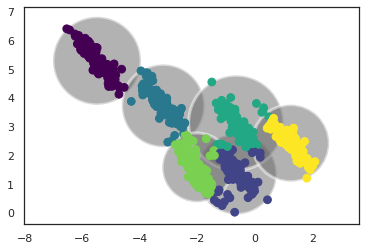

In [122]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=6, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap.
One might imagine addressing this particular situation by preprocessing the data with PCA , but in practice there is no guarantee that such a global operation will circularize the individual data.

These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

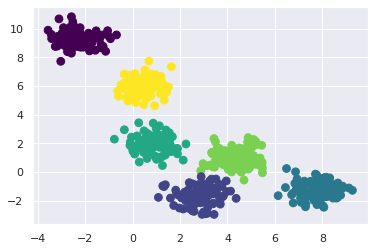

In [42]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=6).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=60, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [43]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

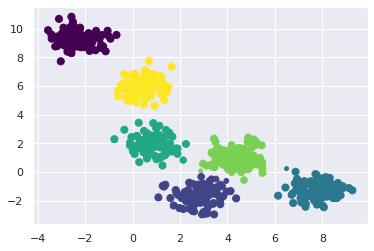

In [44]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

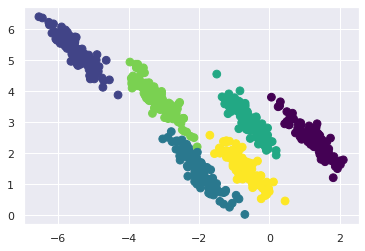

In [52]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full', random_state=42).fit(X_stretched)
gm = gmm.fit_predict(X_stretched)
labels = gmm.predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=60, cmap='viridis');

In [53]:
gm

array([1, 3, 2, 0, 3, 1, 4, 4, 3, 0, 3, 3, 5, 3, 4, 1, 2, 4, 3, 0, 1, 1,
       2, 5, 0, 4, 5, 1, 4, 5, 4, 4, 1, 1, 3, 2, 3, 5, 4, 4, 5, 5, 1, 4,
       1, 2, 1, 1, 5, 2, 0, 0, 1, 4, 0, 0, 1, 2, 1, 1, 2, 4, 4, 2, 2, 2,
       1, 4, 5, 5, 1, 2, 1, 1, 4, 5, 5, 3, 5, 5, 1, 3, 0, 5, 2, 1, 4, 1,
       4, 2, 5, 4, 3, 0, 2, 3, 4, 3, 4, 2, 2, 2, 1, 2, 4, 5, 0, 3, 4, 0,
       2, 0, 5, 5, 5, 5, 4, 3, 4, 5, 5, 5, 0, 0, 2, 0, 5, 1, 4, 0, 0, 0,
       5, 0, 3, 4, 0, 4, 5, 5, 5, 0, 3, 0, 2, 0, 5, 0, 1, 0, 1, 5, 5, 0,
       3, 2, 2, 4, 3, 4, 1, 3, 1, 4, 3, 3, 2, 3, 0, 5, 2, 1, 2, 3, 2, 0,
       1, 2, 5, 5, 3, 0, 3, 5, 2, 0, 5, 4, 3, 4, 4, 3, 5, 1, 5, 3, 1, 3,
       1, 4, 5, 4, 3, 4, 0, 4, 4, 0, 3, 5, 0, 5, 1, 1, 1, 2, 1, 2, 1, 1,
       3, 2, 4, 4, 3, 5, 4, 5, 4, 2, 0, 5, 1, 0, 4, 2, 1, 0, 3, 3, 1, 1,
       1, 3, 4, 4, 2, 1, 1, 5, 1, 5, 1, 1, 5, 2, 3, 1, 3, 2, 4, 1, 3, 4,
       2, 5, 3, 0, 2, 1, 2, 2, 3, 3, 1, 3, 0, 2, 4, 1, 3, 0, 2, 1, 0, 0,
       0, 0, 1, 3, 0, 0, 5, 5, 5, 2, 4, 1, 5, 4, 4,

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

![(Covariance Type)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.12-covariance-type.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Covariance-Type)

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our generated dataset X_stretched:

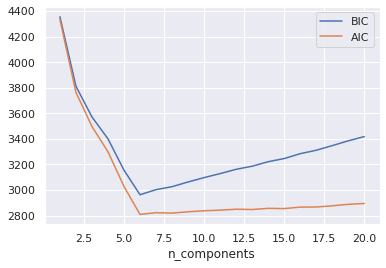

In [55]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X_stretched)
          for n in n_components]

plt.plot(n_components, [m.bic(X_stretched) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_stretched) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 6 components above was probably the best choice.

The BIC appears to back this up.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.

**Computing time performance of models on original data**

In [68]:
import time
elapsed_time = {
    'i': [],
    'km': [],
    'gmm': []
}
for i in range(1, 8):
  km = KMeans(n_clusters=i,
              max_iter=1000,
              tol=1e-4)
  gmm = mixture.GaussianMixture(n_components=i,
                                max_iter= 1000,
                                tol=1e-4)
  
  start_km = time.time()
  km.fit_predict(X)
  end_km = time.time()

  start_gmm = time.time()
  gmm.fit_predict(X)
  end_gmm = time.time()

  elapsed_time['i'].append(i)
  elapsed_time['km'].append(end_km-start_km)
  elapsed_time['gmm'].append(end_gmm-start_gmm)




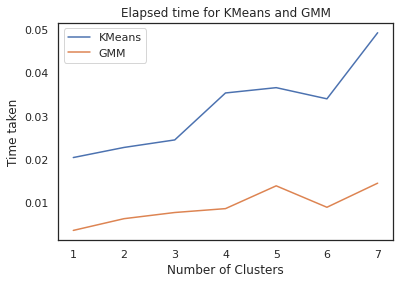

In [69]:
plt.plot(elapsed_time['i'], elapsed_time['km'], label = 'KMeans')
plt.plot(elapsed_time['i'], elapsed_time['gmm'], label = 'GMM')
plt.legend()
plt.title('Elapsed time for KMeans and GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('Time taken')
plt.show()

As can be seen above, the Gaussian Mixture Model performs faster than Kmeans in terms of computation time.

Let us see what happens if the interval for the number of clusters changes from (1,8) to (1, 20):

---



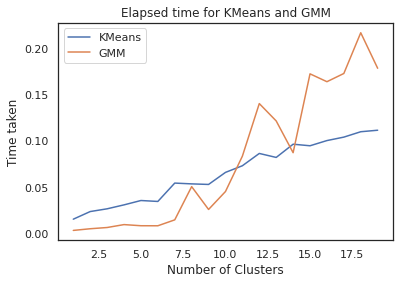

In [70]:
import time
elapsed_time = {
    'i': [],
    'km': [],
    'gmm': []
}
for i in range(1, 20):
  km = KMeans(n_clusters=i,
              max_iter=1000,
              tol=1e-4)
  gmm = mixture.GaussianMixture(n_components=i,
                                max_iter= 1000,
                                tol=1e-4)
  
  start_km = time.time()
  km.fit_predict(X)
  end_km = time.time()

  start_gmm = time.time()
  gmm.fit_predict(X)
  end_gmm = time.time()

  elapsed_time['i'].append(i)
  elapsed_time['km'].append(end_km-start_km)
  elapsed_time['gmm'].append(end_gmm-start_gmm)

plt.plot(elapsed_time['i'], elapsed_time['km'], label = 'KMeans')
plt.plot(elapsed_time['i'], elapsed_time['gmm'], label = 'GMM')
plt.legend()
plt.title('Elapsed time for KMeans and GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('Time taken')
plt.show()


We see that as the number of clusters  increases, computational time for GMM increases significantly vs Kmeans which performs its computations quickly regardless of the range of clusters.

This is due to the simplicity of the nature of the KMeans algorithm vs the Gaussian Mixture Model, even though the Gaussian Mixture Model tends to be more accurate. Or this could be due to the nature of the data provided to the model.

Thus, there will be a need to consider the trade off between speed and accuracy when working with larger datasets, which may results in more clusters.

**Clustering on Iris Dataset**

The Iris dataset can be downloaded <a href = https://www.kaggle.com/uciml/iris> here </a>

The Iris dataset gives the details of the length and breadth of the three flowers: Setosa, Versicolor, Virginica.

In [57]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
sns.set(style="white", color_codes=True)
import warnings
warnings.filterwarnings("ignore")
# show plots inline
%matplotlib inline

In [58]:
#Uploading Iris dataset to Google Colab. If not using Colab, skip this step
data = files.upload()

Saving Iris.csv to Iris.csv


In [59]:
Iris_data = pd.read_csv('Iris.csv')
Iris_data = Iris_data.drop('Id', axis=1) # get rid of the Id column - don't need it
Iris_data.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
8,4.4,2.9,1.4,0.2,Iris-setosa
18,5.7,3.8,1.7,0.3,Iris-setosa
28,5.2,3.4,1.4,0.2,Iris-setosa
49,5.0,3.3,1.4,0.2,Iris-setosa
43,5.0,3.5,1.6,0.6,Iris-setosa


Store the independent and dependent variable in the X and y variables

In [71]:
X = Iris_data.iloc[:,0:4]
y = Iris_data.iloc[:,-1]

In [76]:
y.value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

The classes are extremely well balanced and thus no smoothing (class balancing) algorithms are required.

In [77]:
Iris_data.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


We can however, see that the data itself is unbalanced, as some of the features contain wider ranges of values than others. These features will dominate the dataset. Thus, scaling is needed.

In [79]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns = X.columns)


We can now fit our data using the KMeans Algorithm.

Let the number of initial clusters be 3, since the flower species were divided into 3 categories:

**KMeans Clustering on Iris data**

In [101]:
nclusters = 3 # this is the k in kmeans
seed = 0
km_I = KMeans(n_clusters=nclusters, random_state=seed)
km_I.fit(X_scaled)
# predict the cluster for each data point
y_cluster_kmeans = km_I.predict(X_scaled)



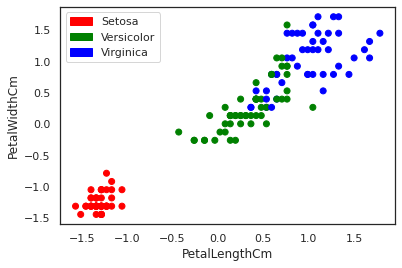

In [82]:
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Setosa')
green_patch = mpatches.Patch(color='green', label='Versicolor')
blue_patch = mpatches.Patch(color='blue', label='Virginica')
colors = np.array(['blue', 'red', 'green'])
plt.scatter(X_scaled.iloc[:, 2],X_scaled.iloc[:, 3],c=colors[y_cluster_kmeans])
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

The above plot provides us with the three clusters. However, we can see that there is some overlapping occuring between the Versicolor and Virginica cluster. Thus, KMeans does not perform very well in clustering this dataset.

**Elbow method to compute optimal number of clusters**

This is designed to help find the optimal number of clusters in a dataset. So let’s use this method to calculate the optimum value of k. To implement the Elbow method, we need to create some Python code (shown below), and we’ll plot a graph between the number of clusters and the corresponding error value.
This graph generally ends up shaped like an elbow, hence its name:

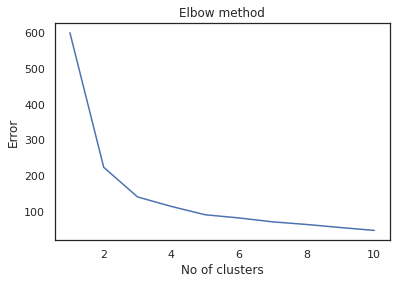

In [102]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X_scaled)
    kmeans.fit(X_scaled)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

As you can see, the optimal value of k is between 2 and 4, as the elbow-like shape is formed at k=3 in the above graph. 

Thus, we can leave the number of clusters as being 3.

**Computing Silhouette Score**

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.
- 1: Means clusters are well apart from each other and clearly distinguished.
- 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
- -1: Means clusters are assigned in the wrong way.

In [84]:
from sklearn import metrics
score = metrics.silhouette_score(X_scaled, y_cluster_kmeans)
score

0.4589717867018717


The silhouette score of 0.46 indicates to us that there is the intermediate distance(neither far nor near) between the clusters.

**Computing Adjusted Rand Score**
The adjusted Rand score is a measure of discrepancy between the true label distribution and the predicted one.

We can thus use the adjusted rand score to quantify the goodness of clustering

In [86]:
from sklearn.metrics.cluster import adjusted_rand_score
score = adjusted_rand_score(y, y_cluster_kmeans) 
score

0.6201351808870379

 From the above result, KMeans gives a score of 0.62 which is pretty decent.

**Gaussian Mixture Modelling on Iris Data**

In [91]:
gmm_I = mixture.GaussianMixture(n_components=3)
gmm_I.fit(X_scaled)
# predict the cluster for each data point
y_cluster_gmm = gmm_I.predict(X_scaled)
y_cluster_gmm

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

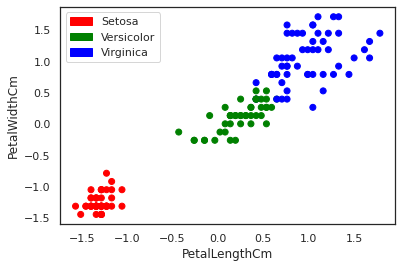

In [92]:
red_patch = mpatches.Patch(color='red', label='Setosa')
green_patch = mpatches.Patch(color='green', label='Versicolor')
blue_patch = mpatches.Patch(color='blue', label='Virginica')
colors = np.array(['blue', 'red', 'green'])
plt.scatter(X_scaled.iloc[:, 2],X_scaled.iloc[:, 3],c=colors[y_cluster_gmm])
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

The plot displays very little overlap between the data points of different clusters, although Versicolor and Virginica are very close to each other.

**Silhouette Score for GMM**

In [94]:
score_GMM = metrics.silhouette_score(X_scaled, y_cluster_gmm)
score_GMM

0.3727731874570307

This silhouette score is closer to 0 than the score for KMeans. This indicates that some of the clusters are not clearly distinguished in terms of distance between them. I.e. they are extremely close to each other. This can be seen in the previous plot.

**Adjusted Rand Score for GMM**

In [95]:
ARS_GMM = adjusted_rand_score(y, y_cluster_gmm)
ARS_GMM

0.9038742317748124

The Gaussian mixture model has an adjusted rand score of 0.9. It thus gives a much better fit of clustering to the dataset than KMeans.

We can once again look at whether the choice of the number of clusters for GMM was the best choice by utilizing the AIC and BIC.

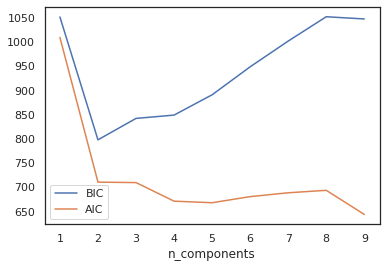

In [96]:
n_components = np.arange(1, 10)
model = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(X_scaled) for m in model], label='BIC')
plt.plot(n_components, [m.aic(X_scaled) for m in model], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

It appears that 2 would have been a better choice for clusters when using GMM based on the graph above. 

However, we know that there are actually 3 distinct classes of flowers in the dataset, regardless of two of them being extremely similar.

Since the values of Versicolor and Virginica were so close together, they are being considered here as one class of flowers. This could be that they are extremely similar in nature and have similar characteristis. 

Remember, this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm.
Thus, it is recommending 2 as the optimal choice due to the two classes of flowers being directly next to each other.

Nonetheless, let us try to implement the GMM using our number of clusters as 2 this time and demonstrate the outcome of this.


In [106]:
gmm_I_2 = mixture.GaussianMixture(n_components=2)
gmm_I_2.fit(X_scaled)
# predict the cluster for each data point
y_cluster_gmm_2 = gmm_I_2.predict(X_scaled)
y_cluster_gmm_2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

No handles with labels found to put in legend.


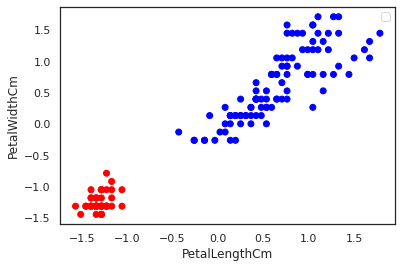

In [112]:
plt.scatter(X_scaled.iloc[:, 2],X_scaled.iloc[:, 3],c=colors[y_cluster_gmm_2])
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.show()

We can see now that Versicolor and Virginica have been combined to form one cluster. This is due to how extremely similar their data points were (how close together they were)

In [114]:
ARS_GMM = adjusted_rand_score(y, y_cluster_gmm_2)
ARS_GMM

0.5681159420289855

However, we see that the adjusted rand score has decreased. Thus, for goodness of clustering, using 3 clusters was indeed the best choice. 


The BIC and AIC scores simply suggest 2 due to the distance between Versicolor and Virginica being extremely small.

We thus conclude that 3 clusters is best and that GMM is the best clustering algorithm to use when compared to Kmeans.

**Computing Elapsed time on Iris Data**

In [116]:
elapsed_time = {
    'i': [],
    'km': [],
    'gmm': []
}
for i in range(1, 8):
  km = KMeans(n_clusters=i,
              max_iter=1000,
              tol=1e-4)
  gmm = mixture.GaussianMixture(n_components=i,
                                max_iter= 1000,
                                tol=1e-4)
  
  start_km = time.time()
  km.fit_predict(X_scaled)
  end_km = time.time()

  start_gmm = time.time()
  gmm.fit_predict(X_scaled)
  end_gmm = time.time()

  elapsed_time['i'].append(i)
  elapsed_time['km'].append(end_km-start_km)
  elapsed_time['gmm'].append(end_gmm-start_gmm)




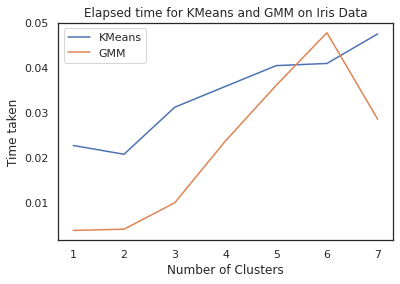

In [117]:
plt.plot(elapsed_time['i'], elapsed_time['km'], label = 'KMeans')
plt.plot(elapsed_time['i'], elapsed_time['gmm'], label = 'GMM')
plt.legend()
plt.title('Elapsed time for KMeans and GMM on Iris Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Time taken')
plt.show()

We see that GMM is computationally faster when being utilized on the iris dataset.

In the paper we cited at the beginning, the authors concluded that the Guassian Mixture Model performed better on their dataset when compared to KMeans, which is the same conclusion we arrive to with our datasets.